## FullAdder - Combinational Circuits

This notebook walks through the implementation of a basic combinational circuit, a full adder. This example introduces many of the features of `Magma` including circuits, wiring, operators, and the type system.

Start by importing `Magma` and `Mantle`. `Magma` is the core system which implements circuits and the methods to compose them, and `Mantle` is a library of useful circuits. 

In [1]:
import magma as m
import mantle

A full adder has three single bit inputs, and returns the sum and the carry. The sum is the *exclusive or* of the 3 bits, the carry is 1 if any two of the inputs bits are 1. Here is a schematic of a full adder circuit (from `logisim`).

![Full Adder](images/full_adder_logisim.png)

We start by defining a Python function that implements a full adder. 
The full adder function takes three single bit inputs and returns two outputs as a tuple.
The first element of tuple is the sum, the second element is the carry.
We compute the sum and carry using standard Python bitwise operators `&`, `|`, and `^`.

In [2]:
def fulladder(A, B, C):
    return A^B^C, A&B|B&C|C&A # sum, carry

We can test our Python function to verify that our implementation behaves as expected. We'll use the standard Python assert pattern.

In [3]:
assert fulladder(1, 0, 0) == (1, 0), "Failed"
assert fulladder(0, 1, 0) == (1, 0), "Failed"
assert fulladder(1, 1, 0) == (0, 1), "Failed"
assert fulladder(1, 0, 1) == (0, 1), "Failed"
assert fulladder(1, 1, 1) == (1, 1), "Failed"
print("Success!")

Success!


Now that we have an implementation of `fulladder` as a Python function, 
we'll use it to construct a `Magma` `Circuit`. 
A `Circuit` in `Magma` corresponds to a `module` in `verilog`.

In [4]:
class FullAdder(m.Circuit):
    name = "FullAdderExample"
    IO = ["I0", m.In(m.Bit), "I1", m.In(m.Bit), "CIN", m.In(m.Bit), "O", m.Out(m.Bit), "COUT", m.Out(m.Bit)]
    @classmethod
    def definition(io):
        O, COUT = fulladder(io.I0, io.I1, io.CIN)
        io.O <= O
        io.COUT <= COUT

First, notice that the `FullAdder` is a subclass of `Circuit`. All `Magma` circuits are classes in python.

Second, the attribute `IO` defines the interface to the circuit. 
`IO` is a list of alternating keys and values. 
The key is the name of the argument, and the value is the type. 
In this circuit, all the inputs and outputs have `Magma` type `Bit`. 
We also qualify each type as an input or an output using the functions `In` and `Out`.

Third, we provide a function `definition`. `definition` must be a class method and this is indicated with the decorator `@classmethod`. 
The purpose of the `definition` function is to create the actual full adder circuit. 
The arguments are passed to `definition` as the object `io`. 
This object has fields for each argument in the interface. 
The body of `definition` calls our previously defined python function `fulladder`.

Note that when we call the python function `fulladder` inside `definition` 
it is passed `Magma` values not standard python values.
When we tested `fulladder` sbove we called it with ints.
When we called it inside `definition` the values passed to the Python `fulladder` function 
are `Magma` values of type `Bit`.
The Python bitwise operators are overloaded to compute logical functions of the `Magma` values (this corresponds to constructing the circuits to compute logical functions `and`, `or`, and `xor`, and wiring inputs to outputs).

`fulladder` returns two values.
These values are assigned to the python variables `O` and `COUT`. 
Remember that assigning to a Python variable 
sets the variable to refer to the object.
`Magma` values are Python objects,
so assigning an object to a variable creates a reference to that `Magma` value.
In order to complete the definition of the circuit, 
`O` and `COUT` need to be *wired* to the outputs in the interface.

The python `<=` operator is overloaded to perform wiring.

Next we simulate the circuit and compare the results to the python function `fulladder`.

In [5]:
from magma.simulator import PythonSimulator

fulladder_magma = PythonSimulator(FullAdder)

assert fulladder_magma(1, 0, 0) == fulladder(1, 0, 0), "Failed"
assert fulladder_magma(0, 1, 0) == fulladder(0, 1, 0), "Failed"
assert fulladder_magma(1, 1, 0) == fulladder(1, 1, 0), "Failed"
assert fulladder_magma(1, 0, 1) == fulladder(1, 0, 1), "Failed"
assert fulladder_magma(1, 1, 1) == fulladder(1, 1, 1), "Failed"
print("Success!")

Success!


Here is another way to test the circuit. 
We define a set of test vectors and plot them in python.

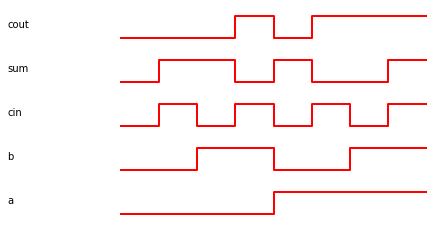

In [6]:
from magma.waveform import waveform

test_vectors_raw = [
    [0, 0, 0, 0, 0],
    [0, 0, 1, 1, 0],
    [0, 1, 0, 1, 0],
    [0, 1, 1, 0, 1],
    [1, 0, 0, 1, 0],
    [1, 0, 1, 0, 1],
    [1, 1, 0, 0, 1],
    [1, 1, 1, 1, 1]
]

waveform(test_vectors_raw, ["a", "b", "cin", "sum", "cout"])

We can use the simulator to also generate a set of test vectors.

In [7]:
from fault.test_vectors import generate_simulator_test_vectors
from bit_vector import BitVector

test_vectors = [
    [BitVector(x) for x in test_vector]
    for test_vector in test_vectors_raw
]

tests = generate_simulator_test_vectors(FullAdder, flatten=False)


Finally, compare the simulated test vectors to the expected values.

In [8]:
print( "Success" if tests == test_vectors else "Failure" )

Success


The last step we will do is generate `coreir` and `verilog` for the full adder circuit.

In [9]:
m.compile("build/FullAdder", FullAdder, output="coreir")
%cat build/FullAdder.json

{"top":"global.FullAdderExample",
"namespaces":{
  "global":{
    "modules":{
      "FullAdderExample":{
        "type":["Record",[
          ["I0","BitIn"],
          ["I1","BitIn"],
          ["CIN","BitIn"],
          ["O","Bit"],
          ["COUT","Bit"]
        ]],
        "instances":{
          "and_inst0":{
            "modref":"corebit.and"
          },
          "and_inst1":{
            "modref":"corebit.and"
          },
          "and_inst2":{
            "modref":"corebit.and"
          },
          "or_inst0":{
            "modref":"corebit.or"
          },
          "or_inst1":{
            "modref":"corebit.or"
          },
          "xor_inst0":{
            "modref":"corebit.xor"
          },
          "xor_inst1":{
            "modref":"corebit.xor"
          }
        },
        "connections":[
          ["self.I0","and_inst0.in0"],
          ["self.I1","and_inst0.in1"],
          ["or_inst0.in0","and_inst0.out"],
          ["self.I1","and_inst1.in0"],
          ["

In [10]:
m.compile("build/FullAdder", FullAdder, output="coreir-verilog")
%cat build/FullAdder.v

module corebit_xor (input in0, input in1, output out);
  assign out = in0 ^ in1;
endmodule

module corebit_or (input in0, input in1, output out);
  assign out = in0 | in1;
endmodule

module corebit_and (input in0, input in1, output out);
  assign out = in0 & in1;
endmodule

module FullAdderExample (input CIN, output COUT, input I0, input I1, output O);
wire and_inst0_out;
wire and_inst1_out;
wire and_inst2_out;
wire or_inst0_out;
wire or_inst1_out;
wire xor_inst0_out;
wire xor_inst1_out;
corebit_and and_inst0(.in0(I0), .in1(I1), .out(and_inst0_out));
corebit_and and_inst1(.in0(I1), .in1(CIN), .out(and_inst1_out));
corebit_and and_inst2(.in0(CIN), .in1(I0), .out(and_inst2_out));
corebit_or or_inst0(.in0(and_inst0_out), .in1(and_inst1_out), .out(or_inst0_out));
corebit_or or_inst1(.in0(or_inst0_out), .in1(and_inst2_out), .out(or_inst1_out));
corebit_xor xor_inst0(.in0(I0), .in1(I1), .out(xor_inst0_out));
corebit_xor xor_inst1(.in0(xor_inst0_out), .in1(CIN), .out(xor_inst1_out));
assign C